In [1]:
!pip install docplex cplex

     |████████████████████████████████| 634 kB 7.7 MB/s 
     |████████████████████████████████| 30.9 MB 56.2 MB/s 
  Created wheel for docplex: filename=docplex-2.22.213-py3-none-any.whl size=696882 sha256=435201f480eb7f8cdb4a40f0aabcd4d17c83f0f341d73c08826f12528c91f921
  Stored in directory: /root/.cache/pip/wheels/90/69/6b/1375c68a5b7ff94c40263b151c86f58bd72200bf0c465b5ba3
Successfully built docplex


In [137]:
#Importing cplex API
import sys
import cplex
import docplex.cp

#Importing numpy and random generator
import numpy as np
rand = np.random

#Importing pyplot
import matplotlib.pyplot as plt

#Importing docplex model
from docplex.mp.model import Model
import itertools

#Imports
from enum import Enum
from cplex.callbacks import UserCutCallback, LazyConstraintCallback
from docplex.mp.callbacks.cb_mixin import *
import networkx as nx

**Definizione classi**

Classe lazy constraints

In [138]:
class LazyCallback(ConstraintCallbackMixin, LazyConstraintCallback):
  def __init__(self, env):
    LazyConstraintCallback.__init__(self, env)
    ConstraintCallbackMixin.__init__(self)

  def __call__(self):
    try:
      # Controlliamo tutti i cicli maggiori di k
      for c in self.C:
        # Salviamo la soluzione trovata senza l'uso di lazy constraints
        y_sol = self.make_complete_solution().get_value_dict(self.y)
        # Controlliamo se il ciclo fa parte della soluzione trovata
        served = sum([y_sol[e] for e in c])

        if not (served <= (len(c) - 1)):
          print('Adding lazy constraint %s <= %d' % 
                (' + '.join(['y(%d)' % (x) for x in c]), len(c) - 1))
          # Aggiungiamo la matrice con il vincolo relativo al ciclo nel modello
          self.add(constraint=cplex.SparsePair(ind=[x for x in c],
                                               val=[y_sol[e] for e in c]), 
                  sense='L', 
                  rhs=(len(c) - 1))
          
    except:
      print(sys.exc_info()[0])
      raise

Classe vertice

In [139]:
class Type(Enum):
  AD = 1
  B = 2
  P = 3


class Vertex:
  def __init__(self, tp, delta_in, delta_out):
    self.tp = tp

    # delta_in = minus
    self.delta_in = delta_in
    
    # delta_out = plus
    self.delta_out = delta_out

**Definizione funzioni**

In [146]:
def get_cycles_edges(C, V):
  edges = []
  aux = []

  for c in C:
    aux = []
    
    for i,_ in enumerate(c):
      if (i + 1) != len(c):
        aux.append(list(set(V[c[i]].delta_out).intersection(set(V[c[i + 1]].delta_in)))[0])
      
      else:
        aux.append(list(set(V[c[i]].delta_out).intersection(set(V[c[0]].delta_in)))[0])
    
    edges.append(aux)

  return edges

**Esempio 1**

In [140]:
E = [i for i in range(0, 8)]    # Edges
V = []  # Vertex
w = [1 for i in range(0, 8)]  # Weigths
k = 3

In [141]:
V.append(Vertex(tp=Type.AD, delta_in=[], delta_out=[0])) # 0
V.append(Vertex(tp=Type.P, delta_in=[0], delta_out=[1])) # 1
V.append(Vertex(tp=Type.P, delta_in=[1], delta_out=[2, 3])) # 2
V.append(Vertex(tp=Type.P, delta_in=[2], delta_out=[4])) # 3
V.append(Vertex(tp=Type.P, delta_in=[3, 5], delta_out=[6])) # 4
V.append(Vertex(tp=Type.P, delta_in=[6], delta_out=[5, 7])) # 5
V.append(Vertex(tp=Type.B, delta_in=[4], delta_out=[])) # 6
V.append(Vertex(tp=Type.B, delta_in=[7], delta_out=[])) # 7

Stampa grafo

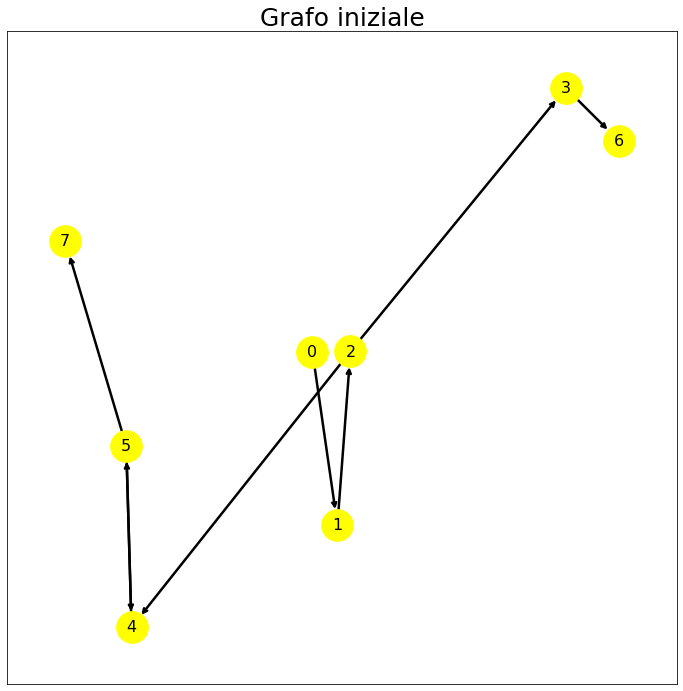

In [142]:
G = nx.DiGraph()
G.add_edges_from([(0, 1), (1, 2), (2, 3), (2, 4), (3, 6), 
                  (4, 5), (5, 4), (5, 7)])

pos = nx.spring_layout(G, seed=13648)
plt.figure(figsize =(12, 12))
plt.title("Grafo iniziale", fontsize=25)

nx.draw_networkx(G, pos=pos, with_labels=True, node_color='yellow', node_size=1000, 
                 font_size=16, arrowstyle="->", width=2.5)

**Esempio 2**

In [152]:
E = [i for i in range(0, 13)]    # Edges
V = []  # Vertex
w = [1 for i in range(0, 13)]  # Weigths
k = 3

In [153]:
V.append(Vertex(tp=Type.P, delta_in=[6, 4, 12], delta_out=[0])) # 0
V.append(Vertex(tp=Type.P, delta_in=[0], delta_out=[1])) # 1
V.append(Vertex(tp=Type.P, delta_in=[1], delta_out=[2, 12])) # 2
V.append(Vertex(tp=Type.P, delta_in=[5], delta_out=[6, 7])) # 3
V.append(Vertex(tp=Type.P, delta_in=[3], delta_out=[4, 5, 9])) # 4
V.append(Vertex(tp=Type.P, delta_in=[2], delta_out=[3, 8])) # 5
V.append(Vertex(tp=Type.B, delta_in=[7], delta_out=[])) # 6
V.append(Vertex(tp=Type.B, delta_in=[9], delta_out=[])) # 7
V.append(Vertex(tp=Type.P, delta_in=[8, 11], delta_out=[10])) # 8
V.append(Vertex(tp=Type.P, delta_in=[10], delta_out=[11])) # 9

Stampa grafo

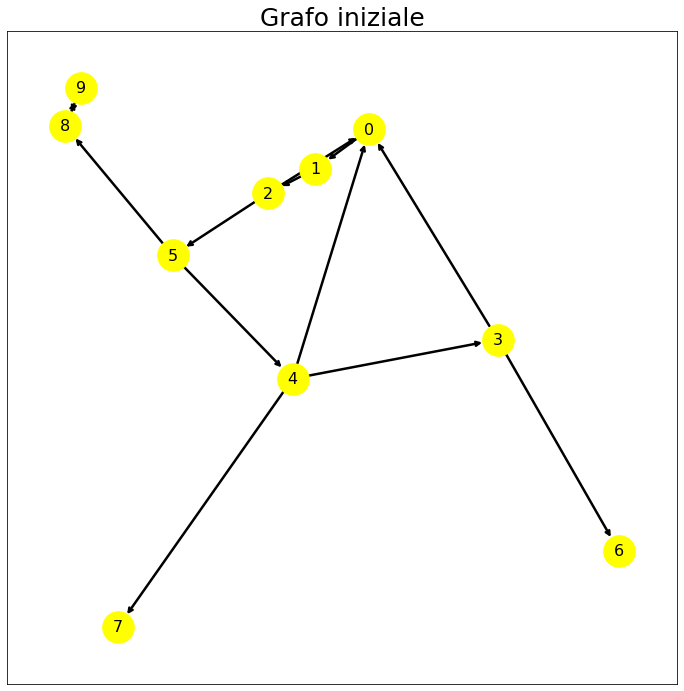

In [154]:
G = nx.DiGraph()
G.add_edges_from([(0, 1), (1, 2), (2, 5), (5, 4), (4, 0), (4, 3), (3, 0), 
                  (3, 6), (5, 8), (4, 7), (8, 9), (9, 8), (2, 0)])

pos = nx.spring_layout(G, seed=13648)
plt.figure(figsize =(12, 12))
plt.title("Grafo iniziale", fontsize=25)

nx.draw_networkx(G, pos=pos, with_labels = True, node_color ='yellow', node_size = 1000, 
                 font_size = 16, arrowstyle="->", width=2.5)

**Definizione modello**

In [155]:
# Model
model = Model('KEP_model')

# Decision variables
y = model.binary_var_dict(E, name='y')
f_in = model.continuous_var_dict(len(V), name='f_in')
f_out = model.continuous_var_dict(len(V), name='f_out')

In [156]:
#Function to minimize
model.maximize(model.sum((w[e] * y[e]) for e in E))

In [157]:
#Constraints
model.add_constraints(model.sum(y[e] for e in V[v].delta_in) == f_in[v] for v,_ in enumerate(V))
model.add_constraints(model.sum(y[e] for e in V[v].delta_out) == f_out[v] for v,_ in enumerate(V))
model.add_constraints((f_out[v] <= f_in[v]) for v,_ in enumerate(V) if V[v].tp == Type.P)
model.add_constraints((f_in[v] <= 1) for v,_ in enumerate(V) if V[v].tp == Type.P)
model.add_constraints((f_out[v] <= 1) for v,_ in enumerate(V) if (V[v].tp == Type.AD or V[v].tp == Type.B))

[docplex.mp.LinearConstraint[](f_out_6,LE,1),
 docplex.mp.LinearConstraint[](f_out_7,LE,1)]

In [158]:
all_cycles = list(nx.simple_cycles(G))
C = []

# Creiamo una lista di tutti i cicli con una lunghezza maggiore di k
for c in all_cycles:
  if len(c) > k:
    C.append(c)

C_edges = get_cycles_edges(C, V)

if len(C) > 0:
  # Aggiungiamo il lazy constraints al modello
  clb = model.register_callback(LazyCallback)
  clb.C = C_edges
  clb.y = y

**Risoluzione modello**

In [159]:
solution = model.solve(log_output=True)
model.solve(log_output=True)

Version identifier: 20.1.0.1 | 2021-12-07 | 9dfdf6686
CPXPARAM_Read_DataCheck                          1
Legacy callback                                  LD
Lazy constraint(s) or lazy constraint/branch callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling presolve reductions that prevent crushing forms (CPX_PARAM_PREREFORM).
         Disabling repeat represolve because of lazy constraint/incumbent callback.
Tried aggregator 2 times.
MIP Presolve eliminated 14 rows and 4 columns.
Aggregator did 14 substitutions.
Reduced MIP has 10 rows, 15 columns, and 28 nonzeros.
Reduced MIP has 13 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.04 ticks)
Probing fixed 3 vars, tightened 0 bounds.
Probing changed sense of 8 constraints.
Probing time = 0.00 sec. (0.01 ticks)
Clique table members: 29.
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.


docplex.mp.solution.SolveSolution(obj=5,values={y_0:1,y_1:1,y_10:1,y_11:..

**Stampa soluzione**

Soluzione

In [160]:
print(solution)

solution for: KEP_model
objective: 5
y_0=1
y_1=1
y_10=1
y_11=1
y_12=1
f_in_0=1.000
f_in_1=1.000
f_in_2=1.000
f_in_8=1.000
f_in_9=1.000
f_out_0=1.000
f_out_1=1.000
f_out_2=1.000
f_out_8=1.000
f_out_9=1.000



Grafo finale

In [161]:
temp = [(u, v) for u,v,i in G.edges(data=True) if (solution.get_value_dict(f_out)[u] == 1) and (solution.get_value_dict(f_in)[v] == 1)]

res = []
for u,v in temp:
  edge = list(set(V[u].delta_out).intersection(set(V[v].delta_in)))[0]
  if solution.get_value_dict(y)[edge] == 1.0:
    res.append((u, v))

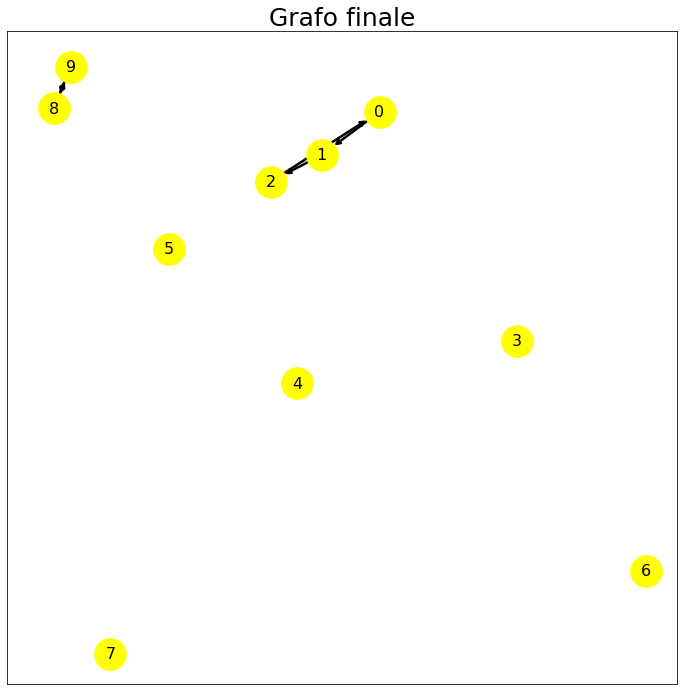

In [162]:
plt.figure(figsize =(12, 12))
plt.title("Grafo finale", fontsize=25)

nx.draw_networkx(G, pos=pos, with_labels=True, node_color='yellow', node_size=1000, 
                 font_size=16, edgelist=res, arrowstyle="->", width=2.5)